### importing packages and libraries

In [2]:
from nba_api.stats.endpoints import LeagueDashPlayerClutch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\nakuf\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### getting data, sorting, allowing inputs etc

In [3]:
# dictionary to map team names to abbreviations
TEAM_NAME_TO_ABBR = {
    "Hawks": "ATL", "Celtics": "BOS", "Nets": "BKN", "Hornets": "CHA",
    "Bulls": "CHI", "Cavaliers": "CLE", "Mavericks": "DAL", "Nuggets": "DEN",
    "Pistons": "DET", "Warriors": "GSW", "Rockets": "HOU", "Pacers": "IND",
    "Clippers": "LAC", "Lakers": "LAL", "Grizzlies": "MEM", "Heat": "MIA",
    "Bucks": "MIL", "Timberwolves": "MIN", "Pelicans": "NOP", "Knicks": "NYK",
    "Thunder": "OKC", "Magic": "ORL", "76ers": "PHI", "Suns": "PHX",
    "Trail Blazers": "POR", "Kings": "SAC", "Spurs": "SAS", "Raptors": "TOR",
    "Jazz": "UTA", "Wizards": "WAS"
}

def get_clutch_stats(team_abbr=None, season="2024-25"):

    # ghets clutch data
    clutch_data = LeagueDashPlayerClutch(
        last_n_games=0,
        clutch_time="Last 5 Minutes",
        point_diff="5",
        season=season,
        season_type_all_star="Regular Season"
    ).get_data_frames()[0]

    # Selects colunms
    clutch_stats = clutch_data[["PLAYER_NAME", "TEAM_ABBREVIATION", "MIN", "PLUS_MINUS", "PTS", "FGA", "FTA"]]

    # Rename columns and round the minutes
    
    clutch_stats = clutch_stats.rename(columns={"PLAYER_NAME": "Player"})
    clutch_stats = clutch_stats.rename(columns={"TEAM_ABBREVIATION": "Team"})
    clutch_stats = clutch_stats.rename(columns={"MIN": "TOTAL_MIN"})
    clutch_stats["TOTAL_MIN"] = np.ceil(clutch_stats["TOTAL_MIN"]).astype(int)

    # calculates TS% and round
    clutch_stats["TS%"] = np.round((clutch_stats["PTS"] / (2 * (clutch_stats["FGA"] + 0.44 * clutch_stats["FTA"]))) * 100, 1)

    # adds filters of at least 20 minutes played and 7 FGA
    clutch_stats = clutch_stats[(clutch_stats["TOTAL_MIN"] >= 20) & (clutch_stats["FGA"] >= 7)]

    # drops columns needed for calculation from showing in output
    clutch_stats = clutch_stats.drop(columns=["FGA", "FTA", "PTS"])

    # Fitlers by input Team Name
    if team_abbr:
        clutch_stats = clutch_stats[clutch_stats["Team"] == team_abbr]

    # Filters by entire League if "NBA" selected
    else:
        clutch_stats = clutch_stats.sort_values(by="PLUS_MINUS", ascending=False).head(15)

    return clutch_stats.sort_values(by="PLUS_MINUS", ascending=False)

# allows user input
while True:
    team_name = input("Enter a full NBA team name (ex., Lakers, Celtics, Raptors) or 'NBA' for the league leaders: ")

    if team_name.lower() == "nba":
        stats = get_clutch_stats()
        print(stats)
        break
    else:
        team_abbreviation = TEAM_NAME_TO_ABBR.get(team_name)
        if team_abbreviation:
            stats = get_clutch_stats(team_abbreviation)
            print(stats)
            break
        else:
            print("Invalid team name. Please enter a valid full NBA team name.")


Enter a full NBA team name (ex., Lakers, Celtics, Raptors) or 'NBA' for the league leaders: Celtics
                 Player Team  TOTAL_MIN  PLUS_MINUS   TS%
193        Jaylen Brown  BOS         86          46  61.3
231        Jrue Holiday  BOS         71          40  59.9
104       Derrick White  BOS         97          37  98.9
198        Jayson Tatum  BOS        108          36  51.6
268  Kristaps Porziņģis  BOS         27          22  51.9
7            Al Horford  BOS         56          16  58.8
343    Payton Pritchard  BOS         44          -1  85.8


In [5]:
# puts celtics data in df
celtics_df = get_clutch_stats("BOS")  
celtics_df

,Player,Team,TOTAL_MIN,PLUS_MINUS,TS%
193,Jaylen Brown,BOS,86,46,61.3
231,Jrue Holiday,BOS,71,40,59.9
104,Derrick White,BOS,97,37,98.9
198,Jayson Tatum,BOS,108,36,51.6
268,Kristaps Porziņģis,BOS,27,22,51.9
7,Al Horford,BOS,56,16,58.8
343,Payton Pritchard,BOS,44,-1,85.8


### Visuals

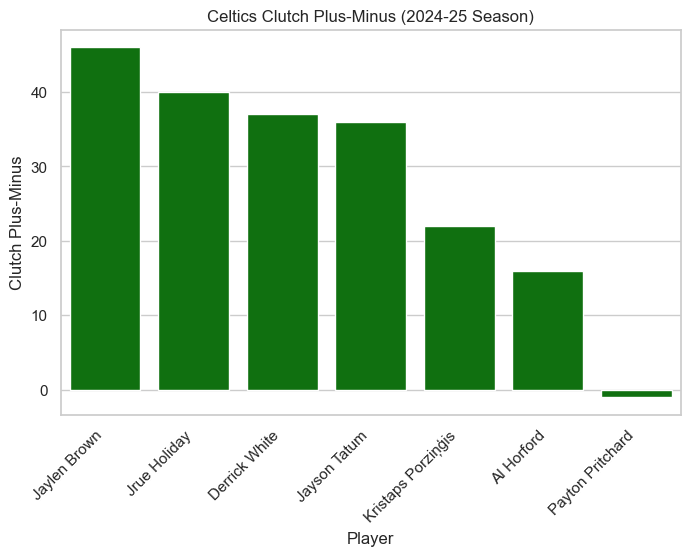

In [9]:
# Bar chart for Celtics players clutch plus minus

def plot_celtics_clutch_performance(celtics_df):
    plt.figure(figsize=(8,5))
    sns.barplot(x="Player", y="PLUS_MINUS", data=celtics_df, color="green", order=celtics_df.sort_values("PLUS_MINUS", ascending=False)["Player"])
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Player")
    plt.ylabel("Clutch Plus-Minus")
    plt.title("Celtics Clutch Plus-Minus (2024-25 Season)")
    plt.show()

plot_celtics_clutch_performance(celtics_df)

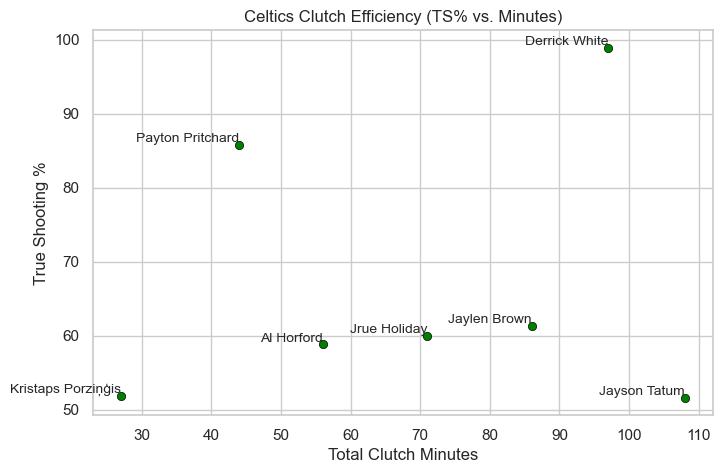

In [10]:
# Scatter plot of TS% vs. Clutch Minutes 

def plot_celtics_clutch_shot_efficiency(celtics_df):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="TOTAL_MIN", y="TS%", data=celtics_df, color="green", edgecolor="black")
    
    # adds player names to points
    for i in range(len(celtics_df)):
        plt.text(celtics_df["TOTAL_MIN"].iloc[i], celtics_df["TS%"].iloc[i], celtics_df["Player"].iloc[i], fontsize=10, ha='right', va='bottom')

    plt.xlabel("Total Clutch Minutes")
    plt.ylabel("True Shooting %")
    plt.title("Celtics Clutch Efficiency (TS% vs. Minutes)")
    plt.show()
plot_celtics_clutch_shot_efficiency(celtics_df)

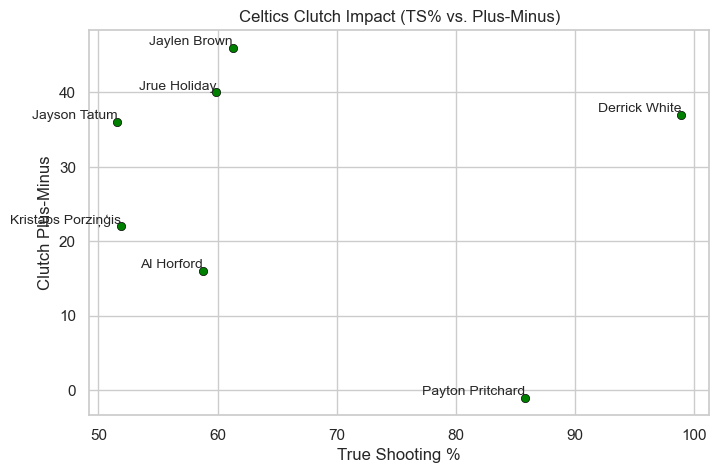

In [12]:
# scatter plot for Plus-Minus vs. TS% 

def plot_celtics_clutch_plus_minus_vs_efficiency(celtics_df):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x="TS%", y="PLUS_MINUS", data=celtics_df, color="green", edgecolor="black")
    
    # adds player names to points
    for i in range(len(celtics_df)):
        plt.text(celtics_df["TS%"].iloc[i], celtics_df["PLUS_MINUS"].iloc[i], celtics_df["Player"].iloc[i], fontsize=10, ha='right', va='bottom')
        
    plt.xlabel("True Shooting %")
    plt.ylabel("Clutch Plus-Minus")
    plt.title("Celtics Clutch Impact (TS% vs. Plus-Minus)")
    plt.show()

plot_celtics_clutch_plus_minus_vs_efficiency(celtics_df)